In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

%matplotlib inline

In [ ]:
def is_state(state): # 0 - 99
    return (state >= 0) and (state < 100)
  
def is_action(action): # 0-1-2-3 -> up right down left
    return (action == 0 or action == 1 or action == 2 or action == 3)

def row_state(state):
    return state % 10

def column_state(state):
    return state // 10

def next_state_after_action(state, action):
    
    state_next = state # if you can not move stay at current state
    
    if(action == 0):   #"UP"
        if(is_state(state-1) and (column_state(state-1)==column_state(state))): 
            state_next= state - 1
    elif(action == 1): #"RIGHT"
        if(is_state(state+10) and (row_state(state+10) == row_state(state))): 
            state_next = state + 10
    elif(action==2):   #"DOWN"
        if(is_state(state+1) and (column_state(state+1)==column_state(state))): 
            state_next = state + 1
    elif(action == 3): #"LEFT"
        if(is_state(state-10) and (row_state(state-10)==row_state(state))): 
            state_next = state - 10
            
    return state_next

def create_transition_matrix(w = 0.1): # 0.1 found from previous part
    n_states = 100
    n_actions = 4
    P = np.zeros((n_states,n_actions,n_states))
    for state in range(n_states):
        for action in range(n_actions):
            P[state][action][next_state_after_action(state,action)] += 1-w
            for wind_action in range(n_actions):
                P[state][action][next_state_after_action(state,wind_action)] += w / 4
    return P

def value_iteration(P, R, epsilon=0.01, gamma=0.8): # epsilon and gamma given, gamma is discount factor
    S = R.shape[0]
    V = np.zeros((S,))
    delta = np.inf
    while delta > epsilon:
        v = V
        V = np.amax(np.matmul(P,R + gamma * V), axis=1)
        delta = np.amax(np.abs(v-V))
    pi_s = np.argmax(np.matmul(P,R + gamma * V), axis=1)
    return [V, pi_s] 

#Plotting function for heatmap
def custom_heatmap(A):
    fig, ax = plt.subplots()
    ax.grid(color = 'black', linewidth = 2)
    ax.set_xlim(0,10)
    ax.set_ylim(10,0)
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.xaxis.tick_top()
    im = ax.pcolor(A.reshape(10,10,order = 'F'))
    fig.colorbar(im)

#Plotting function for general grids, writes numbers in grids
def custom_numbers_grid(A):
    A_grid = A.reshape(10,10,order ="F")
    fig, ax = plt.subplots()
    for i in range(10):
        for j in range(10):
            ax.text(j + 0.5, i + 0.5, round(A_grid[i,j],2), va='center', ha='center',color = "k")

    min_val, max_val = 0, 10
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

#Plotting function for arrow grids, writes arrows in grids
def custom_policy_grid(policy):
    policy_chars = np.chararray((100,),unicode = True)

    arrow_list = ['↑','→','↓','←']
    for i in range(len(arrow_list)):
        policy_chars[np.where(policy == i)] = arrow_list[i]

    policy_grid = policy_chars.reshape(10,10,order = "F")
    
    fig, ax = plt.subplots()
    for i in range(10):
        for j in range(10):
            ax.text(j + 0.5, i + 0.5, policy_grid[i,j], va='center', ha='center')

    min_val, max_val = 0, 10
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

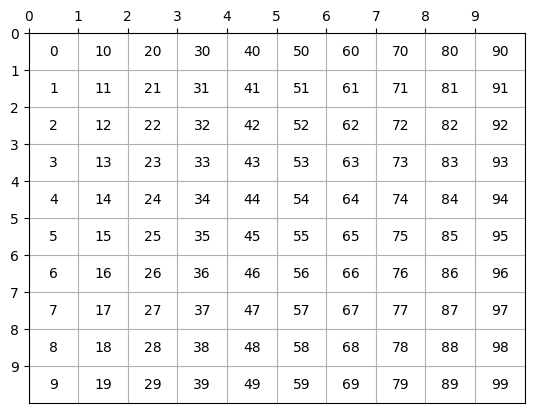

In [ ]:
custom_numbers_grid(np.arange(100))

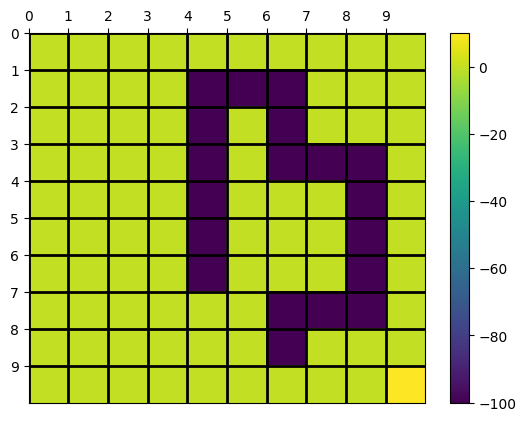

In [ ]:
choose_reward_matrix = 2
if choose_reward_matrix  == 1:
    reward_idx_1 = [14,24,15,25,52,62,53,63,28,38,29,39]
    R1 = np.zeros((100,))
    R1[reward_idx_1] = -10
    R1[99] = 1
else:
    reward_idx_1 = [41,42,43,44,45,46,51,61,62,63,67,68,73,77,83,84,85,86,87]
    R2 = np.zeros((100,))
    R2[reward_idx_1] = -100
    R2[99] = 10
custom_heatmap(R2)

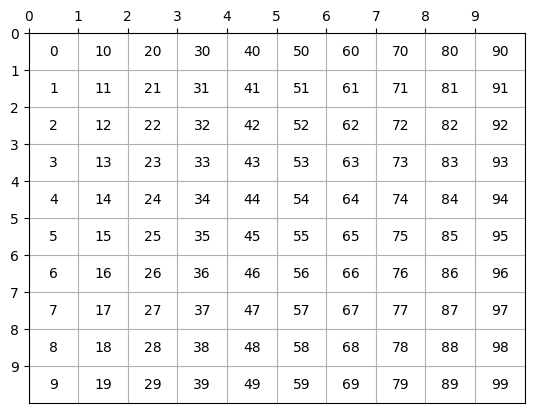

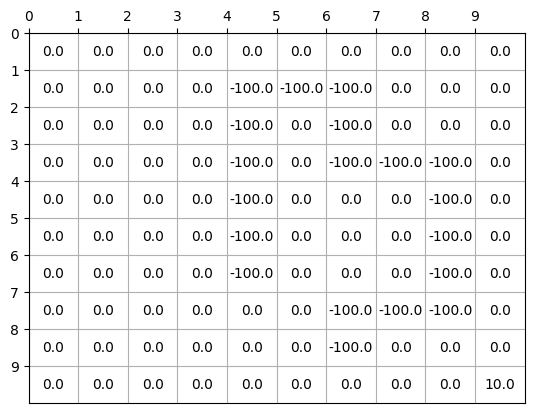

In [ ]:
custom_numbers_grid(np.arange(100))
custom_numbers_grid(R2)

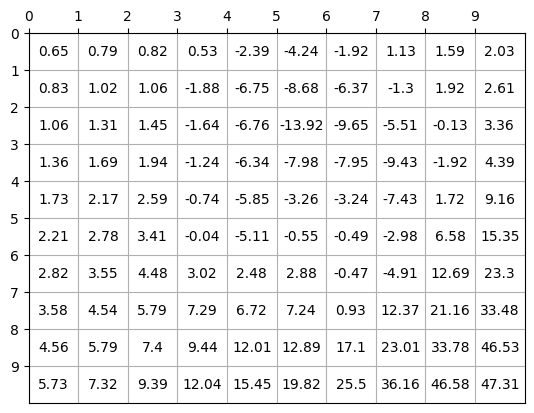

In [ ]:
P = create_transition_matrix() # default w is optimized
V2, policy2 = value_iteration(P,R2)
custom_numbers_grid(V2)

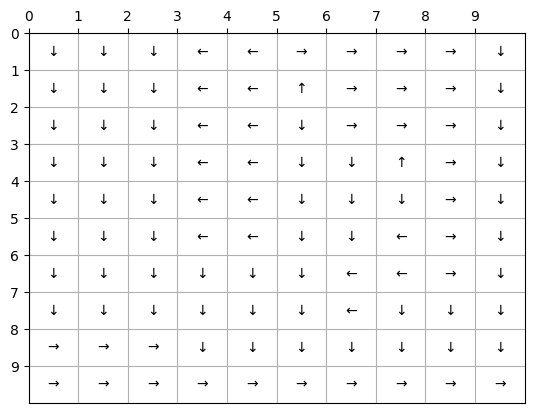

In [ ]:
custom_policy_grid(policy2)

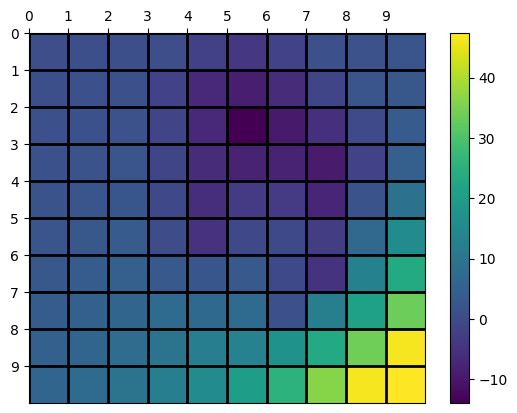

In [ ]:
custom_heatmap(V2)

In [ ]:
def irl_c_D_b(P,policy,lamda,R_max,gamma = 0.8):
    S = P.shape[0]
    c=np.concatenate([np.ones((S,1)), -lamda*np.ones((S,1)), np.zeros((S,1))])
    
    n_action = 4
    Pa_1= np.zeros((S,S))
    Pa_other = np.zeros((n_action-1,S,S))
    
    for state in range(S):
        a_1 = policy[state]
        Pa_1[state,:]=P[state][a_1]
        action_list = [0,1,2,3]
        action_list.remove(a_1)
        for i,action in enumerate(action_list):
            Pa_other[i,state,:]= P[state][action]
            
    I = np.eye(S) 
    Z = np.zeros((S,S))
    
    for i in range(n_action-1):
        Pa = Pa_other[i]
        row1 = np.hstack((I, Z, np.matmul(Pa - Pa_1, np.linalg.inv(I - gamma*np.array(Pa_1)))))
        row12 = np.vstack((row1, np.hstack((Z, Z, np.matmul(Pa - Pa_1, np.linalg.inv(I - gamma*np.array(Pa_1)))))))
        if i == 0:
            D = row12.copy()
        else:
            D = np.vstack((D,row12))
            
    D=np.vstack((D, np.hstack((Z, -I, I))))
    D=np.vstack((D, np.hstack((Z, -I, -I))))
    D=np.vstack((D, np.hstack((Z, Z, I))))
    D=np.vstack((D, np.hstack((Z, Z, -I))))
    b=np.concatenate([np.zeros((2*(n_action-1)*S + 2*S,)), R_max*np.ones((2*S,))])
    return [matrix(c),matrix(D),matrix(b)]

def solve_irl(P,policy,R_max,lamda):
    
    solvers.options['show_progress']= False
    c, D, b = irl_c_D_b(P,policy,lamda,R_max)
    solution=solvers.lp(-c,D,b) # - for maximizing, default lp minimize
    R_predicted = solution['x'][-100:] # R is at the end
    return np.array(R_predicted).squeeze() 

def accuracy_irl(P,expert_policy,Rmax,lamdas):
    accuracy = []
    for i,lamda in enumerate(lamdas):
        R_predicted=solve_irl(P,expert_policy,Rmax,lamda)
        V,predicted_policy=value_iteration(P,R_predicted)
        accuracy.append(np.mean(predicted_policy==expert_policy))
        if(i % 50 == 0): 
            print(i)
    return np.array(accuracy)

0
50
100
150
200
250
300
350
400
450


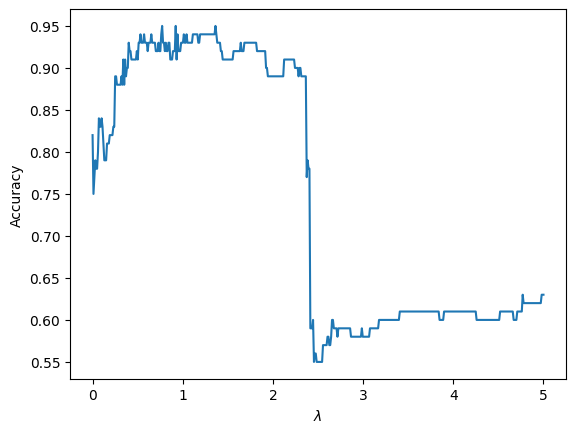

In [ ]:
#Q18
R2_max= np.amax(np.abs(R2)) # For R1 this is 10
lamdas= np.linspace(0,5,500)
accuracy = accuracy_irl(P,policy2,R2_max,lamdas)
plt.plot(lamdas,accuracy)
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
plt.show()

In [ ]:
#Q19
lamda2_max =lamdas[np.argmax(accuracy)]
print("Optimal lambda for agent found in problem 8:"+str(round(lamda2_max, 3))+", giving an accuracy of:"+str(np.amax(accuracy)*100)+" percent.")

Optimal lambda for agent found in problem 8:0.772, giving an accuracy of:95.0 percent.


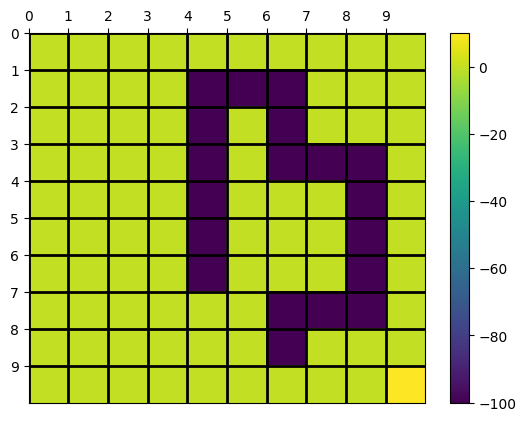

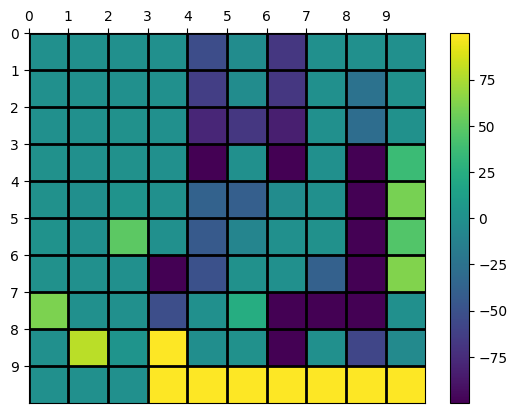

In [ ]:
#Q20
custom_heatmap(R2)
R2_predicted = solve_irl(P,policy2,R2_max,lamda2_max)
custom_heatmap(R2_predicted)

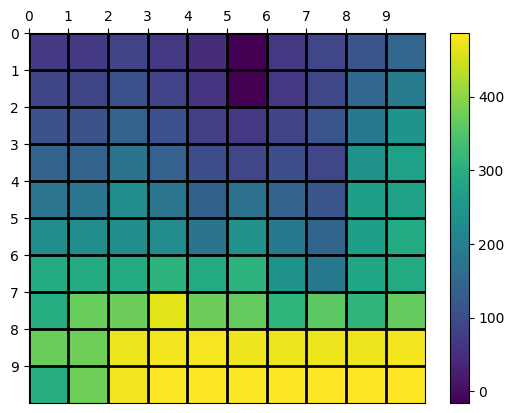

In [ ]:
#Question 21
V2_predicted,predicted_policy2=value_iteration(P,R2_predicted)
custom_heatmap(V2_predicted)

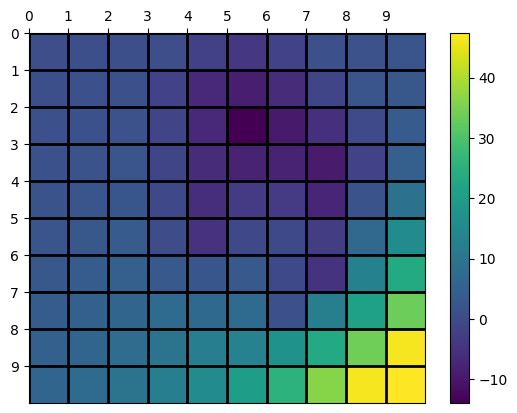

In [ ]:
#Q22
custom_heatmap(V2)

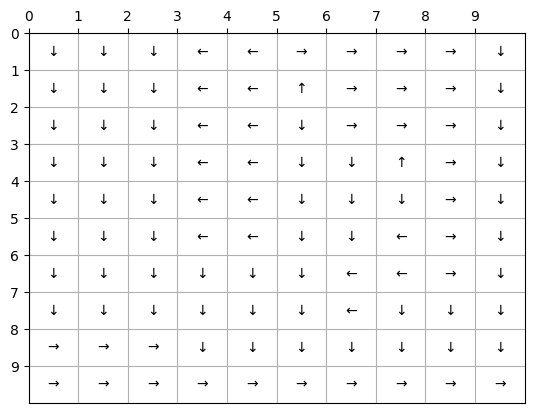

In [ ]:
#Q23
custom_policy_grid(policy2)

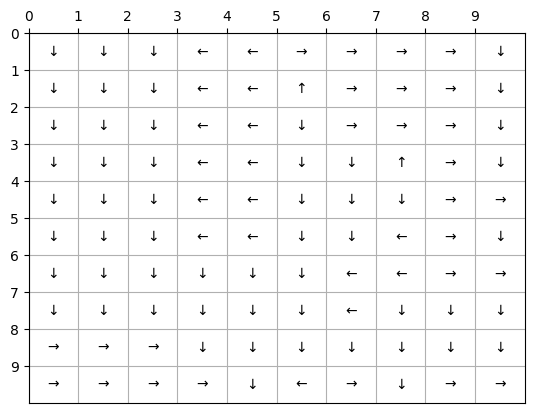

In [ ]:
#Q24
custom_policy_grid(predicted_policy2)

In [97]:
#Q25
def value_iteration(P, R, epsilon=0.001, gamma=0.8): # epsilon and gamma given, gamma is discount factor
    S = R.shape[0]
    V = np.zeros((S,))
    delta = np.inf
    while delta > epsilon:
        v = V
        V = np.amax(np.matmul(P,R + gamma * V), axis=1)
        delta = np.amax(np.abs(v-V))
    pi_s = np.argmax(np.matmul(P,R + gamma * V), axis=1)
    return [V, pi_s] 

0
50
100
150
200
250
300
350
400
450


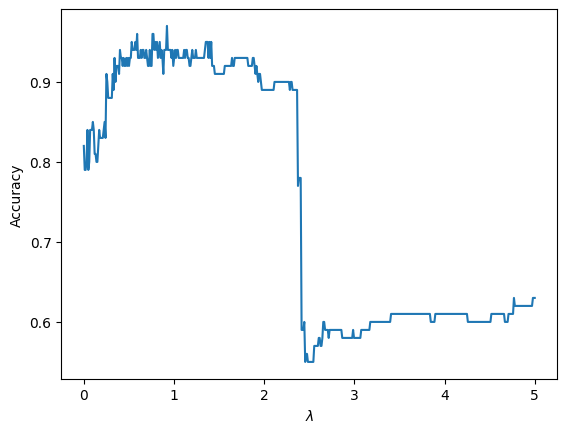

Optimal lambda for agent found in problem 8:0.922, giving an accuracy of:97.0 percent.


In [98]:
#Test modification
P = create_transition_matrix() # default w is optimized
V2, policy2 = value_iteration(P,R2)

R2_max= np.amax(np.abs(R2)) # For R1 this is 10
lamdas= np.linspace(0,5,500)
accuracy = accuracy_irl(P,policy2,R2_max,lamdas)
plt.plot(lamdas,accuracy)
plt.ylabel('Accuracy')
plt.xlabel('$\lambda$')
plt.show()

lamda2_max =lamdas[np.argmax(accuracy)]
print("Optimal lambda for agent found in problem 8:"+str(round(lamda2_max, 3))+", giving an accuracy of:"+str(np.amax(accuracy)*100)+" percent.")


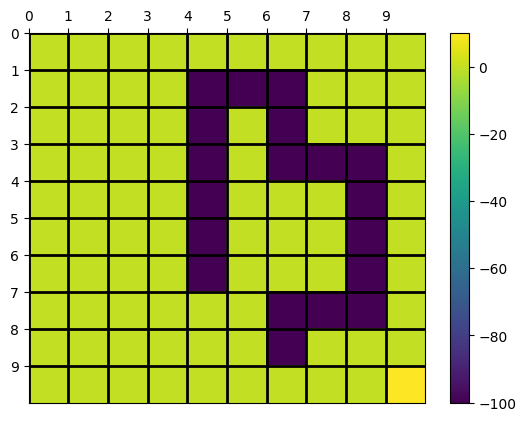

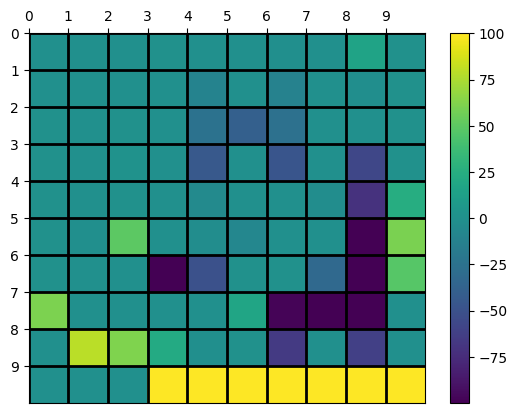

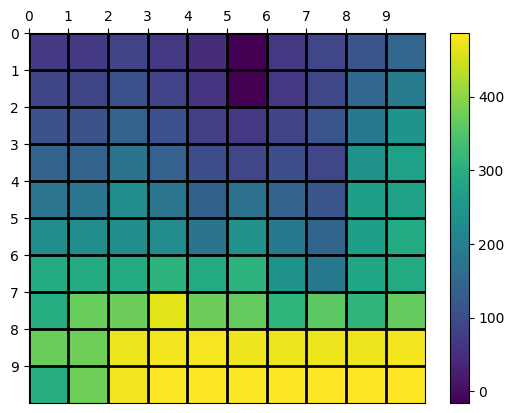

In [99]:
custom_heatmap(R2)
R2_predicted = solve_irl(P,policy2,R2_max,lamda2_max)
custom_heatmap(R2_predicted)

V3_predicted,predicted_policy3=value_iteration(P,R2_predicted)
custom_heatmap(V2_predicted)

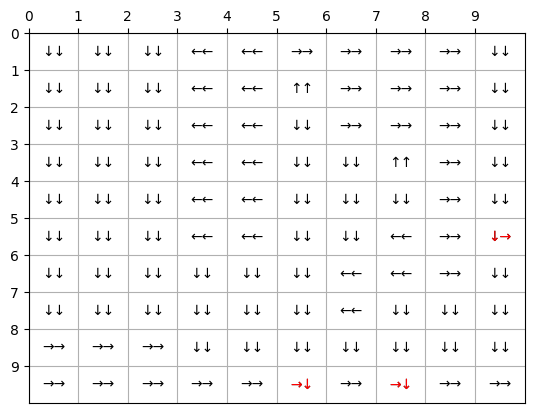

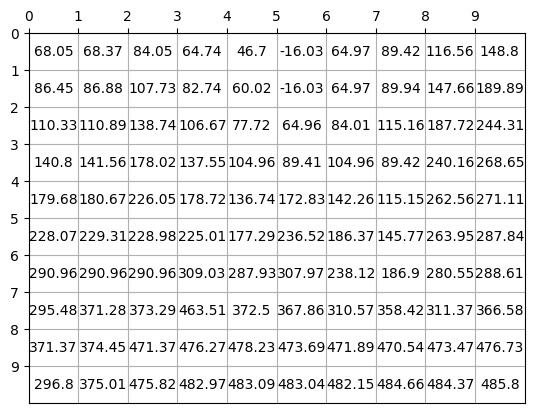

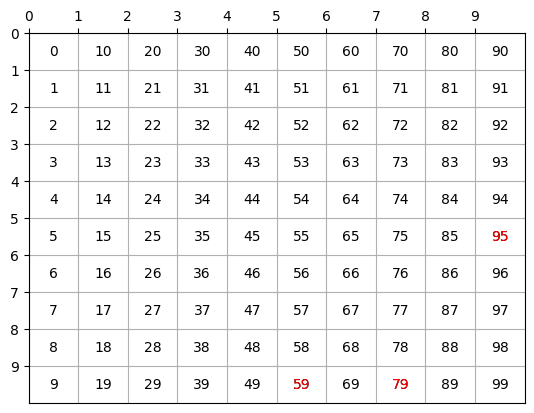

In [100]:
difference = (policy2 - predicted_policy3) != 0
dif_states = np.where(difference)[0]

policy_chars = np.chararray((100,), unicode=True)
policy_chars_predicted = np.chararray((100,), unicode=True)
arrow_list = ['↑','→','↓','←']
for i in range(len(arrow_list)):
        policy_chars[np.where(policy2 == i)] = arrow_list[i]
        policy_chars_predicted[np.where(predicted_policy3 == i)] = arrow_list[i]

concat_chars = policy_chars + policy_chars_predicted

policy_grid = concat_chars.reshape(10,10,order = "F")
fig, ax = plt.subplots()
for i in range(10):
    for j in range(10):
        ax.text(j + 0.5 , i+ 0.5, policy_grid[i,j], va='center', ha='center',color = "black")
        
for k in dif_states:
    i = row_state(k)
    j = column_state(k) 
    ax.text(j + 0.5, i + 0.5, policy_grid[i,j], va='center', ha='center',color = "red")
    
min_val, max_val = 0, 10
    
ax.set_xlim(min_val, max_val)
ax.set_ylim(max_val, min_val)
ax.set_xticks(np.arange(max_val))
ax.set_yticks(np.arange(max_val))
ax.xaxis.tick_top()
ax.grid()

#values
custom_numbers_grid(V2_predicted)




difference = (policy2 - predicted_policy3) != 0
dif_states = np.where(difference)[0]


concat_chars = np.arange(100)
policy_grid = concat_chars.reshape(10,10,order = "F")
fig, ax = plt.subplots()
for i in range(10):
    for j in range(10):
        ax.text(j + 0.5 , i+ 0.5, policy_grid[i,j], va='center', ha='center',color = "black")
        
for k in dif_states:
    i = row_state(k)
    j = column_state(k) 
    ax.text(j + 0.5, i + 0.5, policy_grid[i,j], va='center', ha='center',color = "red")
    
min_val, max_val = 0, 10
    
ax.set_xlim(min_val, max_val)
ax.set_ylim(max_val, min_val)
ax.set_xticks(np.arange(max_val))
ax.set_yticks(np.arange(max_val))
ax.xaxis.tick_top()
ax.grid()